Econometría Aplicada. Lección 2
===============================

**Author:** Marcos Bujosa



<div class="ABSTRACT" id="orgb69a4de">
<p>
En esta lección veremos algunos modelos de regresión con series
temporales; en particular la estimación de componentes (no
observables) con modelos deterministas. También los efectos de la
autocorrelación en las perturbaciones y como lidiar con ellos.
</p>

</div>

-   [lección en html](https://mbujosab.github.io/EconometriaAplicada-SRC/Lecc02.html)
-   [lección en mybinder](https://mybinder.org/v2/gh/mbujosab/EconometriaAplicada-SRC/HEAD?labpath=Lecc02.ipynb)



#### Carga de algunos módulos de python



In [1]:
# Importamos algunos módulos de python
import numpy as np # linear algebra
import pandas as pd # dataframe processing
import statsmodels.api as sm  # modelos estadísticos
import matplotlib as mpl
import matplotlib.pyplot as plt # data visualization
# definimos parámetros para mejorar los gráficos
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5

In [1]:
# Usaré la siguiente función para transformar salidas en \LaTeX{} de statsmodels a ficheros png 
# que incluiré en las transparencias
from sympy.printing.preview import preview
def repr_png(tex, ImgFile):
    preamble = "\\documentclass[10pt,preview]{standalone}\n" \
        "\\usepackage{booktabs,amsmath,amsfonts}\\begin{document}"    
    preview(tex, filename=ImgFile, viewer='file', preamble=preamble, dvioptions=['-D','250'])

##### Lectura datos: Internat. airline passengers. Monthly totals in thousands. Jan 49 – Dec 60



In [1]:
# Leemos los datos de un fichero csv y generamos un dataframe de pandas cuyo índice es el tiempo
OrigData = pd.read_csv('./database/Datasets-master/airline-passengers.csv')
OrigData['Month'] = pd.to_datetime(OrigData['Month'])
OrigData = OrigData.set_index(['Month'])
print(OrigData.head())

In [1]:
# Creamos un dataframe con el mismo índice temporal de los datos originales pero con los datos en logaritmos
TransformedData = pd.DataFrame(index=OrigData.index)
TransformedData['dataLog'] = np.log(OrigData['Passengers'])
print(TransformedData.head())

## Descomposición estructural de una serie temporal



En la lección anterior vimos que una estrategia para analizar series
temporales es transformar los datos para

1.  primero lograr que sean "***estacionarios***" y
2.  después, mediante más transformaciones, lograr una secuencia de
    "**ruido blanco**" (este segundo paso aún no lo hemos abordado)

(*recuerde que las expresiones "datos estacionarios" o secuencia de
"ruido blanco" son un abuso del lenguaje*).



Pero existe otro enfoque que pretende descomponer la serie temporal en
los siguientes componentes *"no observables"* (o en un subconjunto de
ellos):

$$\boldsymbol{y} = \boldsymbol{t} + \boldsymbol{c} + \boldsymbol{s} + \boldsymbol{e}$$

donde:

-   **La tendencia "$\boldsymbol{t}$":** recoge la lenta evolución de la
    media a *largo plazo*.

-   **El componente estacional "$\boldsymbol{s}$":** recoge las
    oscilaciones periódicas que se repiten regularmente en ciclos
    estacionales (de año en año, o de semana en semana, etc.).

-   **El componente cíclico "$\boldsymbol{c}$":** Cuando aparece
    explícitamente en el modelo, $\boldsymbol{c}$ recoge las
    oscilaciones a medio plazo. Es decir, aquellas de un plazo más largo
    que las oscilaciones estacionales, pero más corto que la tendencia
    de largo plazo. Si está ausente, dichas oscilaciones suelen aparecer
    en el componente de la tendencia, que entonces también podemos
    denominar *tendencia-ciclo*.

-   **El componente irregular "$\boldsymbol{e}$":** recoge las
    oscilaciones no captadas por el resto de componentes, ya que debe
    cumplir la siguiente identidad: $\boldsymbol{e} = \boldsymbol{y} -
      \boldsymbol{t} - \boldsymbol{c} - \boldsymbol{s}$.

Ajuste aceptable si (como poco) el componente irregular
$\boldsymbol{e}$ parece "*estacionario*".



### Tendencia determinista *lineal*



In [1]:
# Ajustamos por MCO una tendencia linea. 
# Para ello, primero creamos un DataFrame con el regresando y los regresores del modelo
datosModelo1 = TransformedData[['dataLog']].copy()
nsample = len(datosModelo1)
datosModelo1['cte'] = [1]*nsample
datosModelo1['time'] = np.linspace(1, nsample, nsample)
model1 = sm.OLS(datosModelo1['dataLog'], datosModelo1[['cte', 'time']])
results1 = model1.fit()

In [1]:
#Añadimos al DataFrame =datosModelo1= la tendencia ajustada, los residuos y la diferencia estacional de los residuos.
datosModelo1['yhat'] = datosModelo1['cte']*results1.params['cte']+datosModelo1['time']*results1.params['time']
datosModelo1['ehat'] = results1.resid
datosModelo1['ehatDiff12'] = datosModelo1['ehat'].diff(12)

In [1]:
# Dibujamos los datos junto a la tendencia estimada
plt.plot(datosModelo1['dataLog'])
plt.plot(results1.fittedvalues)
plt.grid()  
plt.ylabel(r"Log-Passengers, ($\ln\boldsymbol{x}$) ")

El modelo de tendencia más simple es la recta de regresión (el
regresor no constante es el índice $t$):

$$\ln{y_t}=\underbrace{\beta_1+\beta_2\cdot t}_{\text{tendencia}} + e_t; \quad t=1:114$$



![img](./img/lecc02/airlinepass+linearTrend.png)

$$\widehat{\ln{y_t}}=4.8137+0.01\cdot\big(t\big), \qquad t=1:114$$



In [1]:
print(results1.summary())

![img](./img/lecc02/resultsModel1.png)



**<u>Componente irregular</u>**



In [1]:
# Gráfico de los residuos del ajuste.
plt.grid()  
plt.plot(results1.resid)

![img](./img/lecc02/airlinepass+irreg.png)

En este caso, el modelo 

$$\boldsymbol{y} = \boldsymbol{t} + \boldsymbol{e}$$

donde $\boldsymbol{t}$ es una tendencia lineal no
es un ajuste satisfactorio, pues el *componente irregular*
$$\boldsymbol{e}=\boldsymbol{y}-\boldsymbol{t}$$
no tiene la apariencia de realización de un proceso estacionario.



In [1]:
# Gráfico de la diferencia estacional de los residuos del ajuste.
plt.grid()  
plt.plot(datosModelo1['ehatDiff12'])

Adicionalmente podemos ver que diferencia de orden 12 del componente
irregular parece mostrar un componente cíclico con un periodo de unos
4 años.

![img](./img/lecc02/airlinepass+irregDiff12.png)

En el siguiente ejercicio probaremos con una tendencia cuadrática&#x2026;



### Tendencia determinista *cuadrática*



In [1]:
# creamos un DataFrame con el regresando y los regresores del modelo :results silent.
datosModelo2 = TransformedData[['dataLog']].copy()
nsample = len(datosModelo1)
datosModelo2['cte'] = [1]*nsample
datosModelo2['time'] = np.linspace(1, nsample, nsample)
datosModelo2['sq_time'] = [t**2 for t in datosModelo2['time']]
# Ajustamos por MCO una tendencia cuadrática a los datos.
model2 = sm.OLS(datosModelo1['dataLog'], datosModelo2[['cte', 'time', 'sq_time']])
results2 = model2.fit()

ajuste-tendencia-cuadratica

In [1]:
# Añadimos al DataFrame 'datosModelo2' la tendencia ajustada, los residuos y la diferencia estacional de los residuos.
datosModelo2['yhat'] = results2.fittedvalues
datosModelo2['ehat'] = results2.resid
datosModelo2['ehatDiff12'] = datosModelo2['ehat'].diff(12)

In [1]:
# Dibujamos los datos junto a la tendencia estimada.
plt.plot(datosModelo1['dataLog'])
plt.plot(results2.fittedvalues)
plt.grid()  
plt.ylabel(r"Log-Passengers, ($\ln\boldsymbol{x}$) ")

$$\ln{y_t}=\underbrace{\beta_1+\beta_2\cdot t + \beta_3\cdot t^2}_{\text{tendencia}} + e_t; \quad t=1:114$$



![img](./img/lecc02/airlinepass+quadraticTrend.png)

$$\widehat{\ln{y_t}}=4.7364+(0.0132)\cdot t +(-2.191e-05)\cdot t^2, \qquad t=1:114$$



In [1]:
print(results2.summary())

#+begin_example
                            OLS Regression Results                            
Dep. Variable:                dataLog   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     691.0
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           1.37e-73
Time:                        16:38:00   Log-Likelihood:                 85.260
No. Observations:                 144   AIC:                            -164.5
Df Residuals:                     141   BIC:                            -155.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cte            4.7364      0.034    

![img](./img/lecc02/resultsModel2.png)



**<u>Componente irregular</u>**



| <matplotlib.lines.Line2D | at | 0x7fdeace02350> |


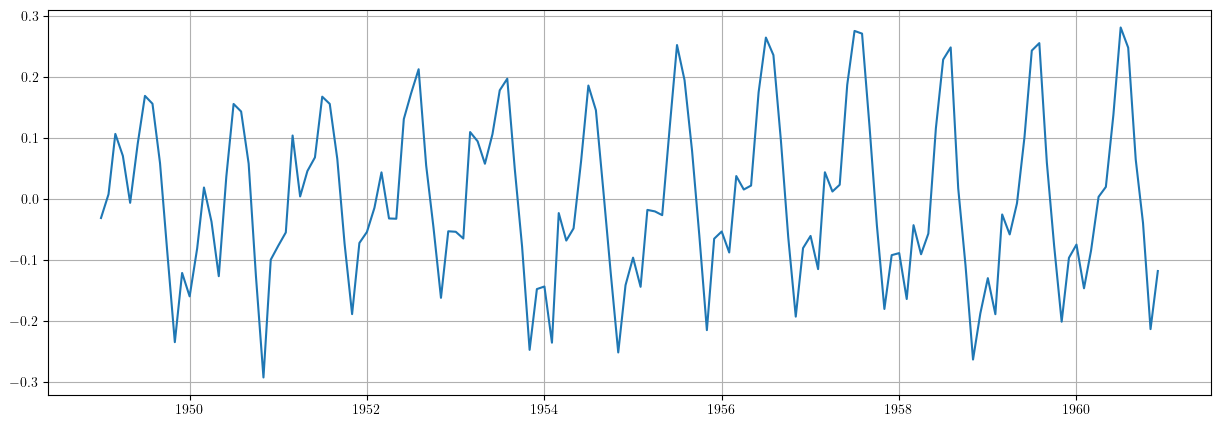

In [1]:
plt.grid()  
plt.plot(results2.resid)

![img](./img/lecc02/airlinepass+irreg2.png)

De manera análoga al caso anterior, el modelo

$$\boldsymbol{y} = \boldsymbol{t} + \boldsymbol{e}$$

donde $\boldsymbol{t}$ ahora es una *tendencia
cuadrática* tampoco es un ajuste satisfactorio, pues el componente
irregular $\boldsymbol{e}$ sigue sin parecerse a la realización de un
proceso estacionario.



In [1]:
plt.grid()  
plt.plot(datosModelo2['ehatDiff12'])

También en este modelo la diferencia de orden 12 del componente
irregular muestra un componente cíclico con un periodo de unos 4 años.

![img](./img/lecc02/airlinepass+irregDiff12.png)

Para obtener una *tendencia-ciclo* que capte este ciclo, son
necesarios procedimientos más sofisticados (por ejemplo TRAMO-SEATS, o
X13-ARIMA, o STAMP, o LDHR, o E4, etc.) que estiman tendencias y
componentes estacionales estocásticos.



En el siguiente ejercicio estimaremos un **componente estacional
determinista** (junto a una tendencia cuadrática determinista).



### Tendencia cuadrática más estacionalidad determinista mediante *dummies*



In [1]:
# Creamos un dataframe con los datos y los regresores 'cte', 't' y ' :results silentt^2'
df = TransformedData[['dataLog']].copy()
nsample = len(df)
df['cte']     = [1]*nsample
df['time']    = np.linspace(1, nsample, nsample)
df['sq_time'] = [t**2 for t in df['time']]

In [1]:
# Creamos las /dummies/ estacionales
from statsmodels.tsa.deterministic import Seasonality
seas_gen = Seasonality(12, initial_period=1)
seasonalDummies = seas_gen.in_sample(df.index)

In [1]:
# Creamos un dataframe con el regresando y todos los regresores del modelo
datosModelo3 = pd.concat([df, seasonalDummies],axis=1)
# realizamos la regresión de la primera columna ('dataLog') sobre el resto de columnas del dataframe.
model3 = sm.OLS(datosModelo3['dataLog'], datosModelo3.iloc[:,1:-1])
results3 = model3.fit()

In [1]:
# La combinación lineal de los regresores 'cte', 'time' y 'sq_time' usando los correspondientes
# parámetros estimados nos da el componente de tendencia (determinista) estimado. 
TrendComp = datosModelo3[['cte','time','sq_time']].dot(results3.params[['cte','time','sq_time']])

In [1]:
rcParams['figure.figsize'] = 15,4
plt.plot(datosModelo1['dataLog'])
plt.plot(TrendComp)
plt.grid()  
plt.ylabel(r"Log-Passengers, ($\ln\boldsymbol{x}$) ")

![img](./img/lecc02/airlinepass+TrendC.png)



In [1]:
SeasonalComp = (seasonalDummies.iloc[:,:-1]).dot(results3.params[3:])
plt.grid()  
plt.plot(SeasonalComp)

![img](./img/lecc02/airlinepass+SeasonalC.png)



#### Ajuste y componente irregular $\boldsymbol{e}=\boldsymbol{y}-\boldsymbol{t}-\boldsymbol{s}$



In [1]:
plt.grid()  
plt.plot(datosModelo3['dataLog'])
plt.plot(TrendComp + SeasonalComp)

![img](./img/lecc02/airlinepass+yhat.png)



In [1]:
plt.grid()  
plt.plot(results3.resid)

![img](./img/lecc02/airlinepass+IrregC.png)



#### Valoración de modelos con componentes deterministas



-   Estos modelos resultan útiles para realizar un análisis descriptivo.

-   Pero suelen funcionar bastante mal como herramienta de predicción:
    -   no tienen en cuenta la dependencia inter-temporal de los datos (se
        han estimado mediante una regresión como si los datos hubieran
        sido de sección cruzada)
    
    -   Por ejemplo, a la hora de prever el dato de enero de 1961, en este
        modelo pesa tanto el dato de enero de 1949 como el dato de enero
        de 1960.

En general, para que los modelos funcionen bien en predicción deben
*dar un mayor peso a los datos recientes* frente a los datos alejados
en el tiempo.

Pero sigamos explorando este modelo&#x2026;



**Hay parámetros no significativos&#x2026;** (p-valores para dummies enero,
febrero y octubre).



In [1]:
repr_png(results3.summary().as_latex(), "./img/lecc02/resultsModel3.png")

<div>
<img src="./img/lecc02/resultsModel3.png" width="400" class="center"/>
</div>



**podemos eliminarlos secuencialmente** (quitando cada vez la variable de mayor p-valor)



In [1]:
import operator
def remove_most_insignificant(df, results):
    # use operator to find the key which belongs to the maximum value in the dictionary:
    max_p_value = max(results.pvalues.items(), key=operator.itemgetter(1))[0]
    # this is the feature you want to drop:
    df.drop(columns = max_p_value, inplace = True)
    return df

In [1]:
y = datosModelo3['dataLog']
X = datosModelo3.iloc[:,1:-1]
significacion = 0.05
insignificant_feature = True
while insignificant_feature:
        model4 = sm.OLS(y, X)
        results4 = model4.fit()
        significant = [p_value < significacion for p_value in results4.pvalues]
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results4 = None
                insignificant_feature = False
            else:            
                X = remove_most_insignificant(X, results4)

print(results4.summary())

<div>
<img src="./img/lecc02/resultsModel4.png" width="400" class="center"/>
</div>



Pero esta inferencia es incorrecta. Con auto-correlación la varianza
del estimador MCO es diferente (**la estimación por defecto de las
desviaciones típicas es incorrecta**)



## Perturbaciones no esféricas



Considere el modelo
$\boldsymbol{y}=\boldsymbol{\mathsf{X}\beta}+\boldsymbol{U}.\;$ Bajo
los supuestos habituales

$$E(\boldsymbol{U}\mid\boldsymbol{\mathsf{X}})=\boldsymbol{0},\quad
Var(\boldsymbol{U}\mid\boldsymbol{\mathsf{X}})=\sigma^2\boldsymbol{\mathsf{I}}\quad
\text{y} \quad E(\boldsymbol{\mathsf{X'X}}) \text{ es invertible}$$

el estimador
$\;\widehat{\boldsymbol{\beta}}=(\boldsymbol{\mathsf{X'X}})^{-1}\boldsymbol{\mathsf{X'}Y}\;$
es insesgado y eficiente, con varianza

$$\;Var(\widehat{\boldsymbol{\beta}}\mid\boldsymbol{\mathsf{X}})=\sigma^2(\boldsymbol{\mathsf{X'X}})^{-1}$$



Pero si las perturbaciones $\boldsymbol{U}$ del modelo son
heterocedásticas y/o autocorreladas
$$Var(\boldsymbol{U}\mid\boldsymbol{\mathsf{X}})=\boldsymbol{\Sigma}\ne\sigma^2\boldsymbol{\mathsf{I}}$$
entonces el estimador $\widehat{\boldsymbol{\beta}}$, aunque
insesgado, ya no es eficiente; y su varianza es

$$Var(\widehat{\boldsymbol{\beta}}\mid\boldsymbol{\mathsf{X}})=Var(\widehat{\boldsymbol{\beta}}-\boldsymbol{\mathsf{I}}\boldsymbol{\beta}\mid\boldsymbol{\mathsf{X}})=
(\boldsymbol{\mathsf{X'X}})^{-1}\boldsymbol{\mathsf{X'}}
\boldsymbol{\Sigma}
\boldsymbol{\mathsf{X}}(\boldsymbol{\mathsf{X'X}})^{-1}.$$



### Test de autocorrelación de Breusch y Godfrey



El tests Breusch-Godfrey (y el Durbin-Watson) contrastan la $H_0$ de *no autocorrelación*.




Considere el *modelo de regresión lineal* 

\begin{equation}
\label{org1bb5792}
Y_t = \beta_1+ \beta_2 X_{t,1} + \cdots +  \beta_k X_{t,k+1} + U_t 
\end{equation}


donde las perturbaciones $\boldsymbol{U}$ quizá siguen un esquema
auto-regresivo $AR(p)$:

$$U_t = \rho_1 U_{t-1} + \rho_2 U_{t-2}  + \cdots + \rho_p U_{t-p} + \varepsilon_t$$

-   **Paso 1**. Obtener los errores $\hat{\boldsymbol{e}}$ de ajuste MCO
    de ([1](#org1bb5792)) (muestra de tamaño $T$)
-   **Paso 2**. Calcular el $R^2$ de la *regresión auxiliar* de los
    errores $\hat{\boldsymbol{e}}$ sobre los regresores del modelo
    original ([1](#org1bb5792)) y sobre los $p$ primeros retardos
    de $\hat{\boldsymbol{e}}$.  $$\hat{e}_t = \alpha_0 + \alpha_1
      X_{t,1} + \cdots \alpha_k X_{t,k} + \rho_1 \hat{e}_{t-1} + \rho_2
      \hat{e}_{t-2} + \cdots + \rho_p \hat{e}_{t-p} + \varepsilon_t$$

Asintóticamente y bajo la $H_0$ de *no autocorrelación*: $\quad\rho_i = 0\text{ para todo }i$

$$n R^2\,\sim\,\chi^2_p,$$


donde $R^2$ es el coeficiente de determinación de la regresión
auxiliar y $n=T-p$.



**El test de Durbin-Watson** contrasta la autocorrelación <u>de orden
uno</u>. Para muestras grandes, el test es aproximadamente igual a
$2(1-{\hat {\rho }})$, donde ${\hat{\rho}}$ es la autocorrelación de
orden uno de los residuos. Por tanto, valores del test próximos a 2
indican no autocorrelación, valores próximos a 0 indican fuerte
autocorrelación positiva y valores próximos a 4 indican fuerte
autocorrelación negativa.



In [1]:
import statsmodels.stats.diagnostic as dg
#perform Breusch-Godfrey t :results silentest of order p = 3
arbg = dg.acorr_breusch_godfrey(results4, nlags=3, store=True)
arbg[:1]
repr_png(arbg[-1].resols.summary().as_latex(), "./img/lecc02/resultsBreusch-Godfrey.png")

-   Valor del estadístico: $\quad \qquad$ (p-valor: $\; 1.55e-13$)
-   $x_{12}$ corresponde al primer retardo en la regresión auxiliar y es muy significativo

<div>
<img src="./img/lecc02/resultsBreusch-Godfrey.png" width="450" class="center"/>
</div>



### Errores estándar robustos



Un procedimiento adecuado en presencia de autocorrelación y muestras
grandes consiste en usar errores estándar *robustos* (**HAC** -
heteroscedasticity and autocorrelation robust covariance matrix) al
realizar inferencia con la estimación de los parámetros.

1.  las estimaciones serán insesgadas, consistentes pero ineficientes,

2.  los residuos son los mismos y, por tanto, estarán autocorrelados, aunque

3.  la inferencia a partir de errores estándar robustos será válida



In [1]:
y = datosModelo3['dataLog']
X = datosModelo3.iloc[:,1:-1]
model5 = sm.OLS(y, X)
results5 = model5.fit()
print(results5.get_robustcov_results(cov_type='HAC', maxlags=3, use_correction=True).summary())

In [1]:
repr_png(results5.get_robustcov_results(cov_type='HAC', maxlags=3, use_correction=True).summary().as_latex(), "./img/lecc02/resultsModel5.png")

-   **Covariance type**: HAC (heteroscedasticity and autocorrelation robust covariance matrix)

<div>
<img src="./img/lecc02/resultsModel5.png" width="400" class="center"/>
</div>

Ahora, y empleando errores estándar robustos (HAC), podemos reducir el
modelo de manera más cuidadosa usando desviaciones típicas
robustas. El modelo reducido es&#x2026;



In [1]:
y = datosModelo3['dataLog']
X = datosModelo3.iloc[:,1:-1]

significacion = 0.05

insignificant_feature = True
while insignificant_feature:
        results6      = sm.OLS(y, X).fit()
        robustResults = results6.get_robustcov_results(cov_type='HAC', maxlags=3, use_correction=True)
        robustPvalues = pd.Series(index=results6.pvalues.index, data=robustResults.pvalues)

        significant = [p_value < significacion for p_value in robustPvalues]

        
        if all(significant):
            insignificant_feature = False
        else:
            if X.shape[1] == 1:  # if there's only one insignificant variable left
                print('No significant features found')
                results6 = None
                insignificant_feature = False
            else:            
                X = remove_most_insignificant(X, results6)
print(robustResults.summary())
repr_png(robustResults.summary().as_latex(), "./img/lecc02/resultsModel6.png")

<div>
<img src="./img/lecc02/resultsModel6.png" width="400" class="center"/>
</div>

-   Nótese que ahora (HAC) se aprecia que enero y octubre son significativos al 5%
-   Pero la estimación MCO no es eficiente en presencia de auto-correlación



### Modelo del error



En el modelo
$\boldsymbol{y}=\boldsymbol{\mathsf{X}\beta}+\boldsymbol{U},\;$ si las
perturbaciones presentan heterocedasticidad y/o auto-correlación, y
por tanto
$$Var(\boldsymbol{U}\mid\boldsymbol{\mathsf{X}})=\boldsymbol{\Sigma}\ne\sigma^2\boldsymbol{\mathsf{I}},$$
el Teorema de Gauss-Markov ya no es válido, ya que es posible explotar
la estructura de la matriz $\boldsymbol{\Sigma}$ para minimizar la
varianza del estimador.

En particular, el estimador lineal de mínima varianza es el estimador
MCG (mínimos cuadrados generalizados)

$$\;\widehat{\boldsymbol{\beta}}=(\boldsymbol{\mathsf{X'}}\boldsymbol{\mathsf{\Sigma}}^{-1}\boldsymbol{\mathsf{X}})^{-1}\boldsymbol{\mathsf{X'}}\boldsymbol{\mathsf{\Sigma}}^{-1}\boldsymbol{y}\;$$

El problema es que, en general, la matriz $\boldsymbol{\Sigma}$ es
desconocida.

Una solución es aplicar un procedimiento iterativo en el que se estima
la matriz $\boldsymbol{\Sigma}$ empleando los errores del ajuste de
una primera regresión. Con dicha matriz
$\widehat{\boldsymbol{\Sigma}}$ se re-estima el modelo por MCG&#x2026; con
los nuevos errores se re-estima $\boldsymbol{\Sigma}$&#x2026; y vuelta a
empezar&#x2026;

El algoritmo se detiene cuando las estimaciones convergen a valores
estables.



Cuando realizamos el Test de Breusch-Godfrey vimos que en la regresión
auxiliar el primer retardo de los errores era significativo. Por
tanto, vamos a indicar que las perturbaciones siguen un proceso AR(1).
El decir, vamos a estimar el modelo

$$\ln{y_t}=\underbrace{\beta_1+\beta_2\cdot t+\beta_3\cdot t^2}_{\text{tendencia}} + \underbrace{\alpha_1 S_{t1} + \alpha_3 S_{t3} + \cdots + \alpha_11 S_{t11}}_{\text{comp. estacional}} + \epsilon_t$$

donde las perturbaciones $\boldsymbol{\epsilon}=\{\epsilon_t\}$ siguen
el modelo

$$\epsilon_t = \rho_1 \epsilon_{t-1} + e_t$$

(*en este caso la estimación (**GLSAR**) converge en 7 iteraciones*)



In [1]:
model = sm.GLSAR(y, X, rho=1) # :results silent rho=1 indica autocorrelación de orden uno
for i in range(7):
    results = model.fit()
    print("AR coefficients: {0}".format(model.rho))
    rho, sigma = sm.regression.yule_walker(results.resid,
                                           order=model.order)
    model = sm.GLSAR(y, X, rho)

In [1]:
print(results.summary())

<div>
<img src="./img/lecc02/resultsModel7.png" width="600" class="center"/>
</div>



In [1]:
# este código realiza las mismas iteraciones que bloque de código de más arriba
model2 = sm.GLSAR(y, X, rho=1)
res = model2.iterative_fit(maxiter=7)
model2.rho
print(model2.fit().summary())